Generation 5 - First Candidate: [0.73335982 0.7292649  0.17675505 0.90564648 0.28298052 0.
 0.09950734 0.73342841 0.61886097 0.28187217 0.         0.40001625
 0.9009944  0.1269477  0.         0.63343272 0.39863401 1.
 0.66970728 0.         0.15187803 0.         0.25135433 0.61007918
 0.10251765 0.14051711 0.3741382  0.         0.30851036 0.53171396]
Objective Values: [0.73335982 2.47387449]
Generation 50 - First Candidate: [4.87411256e-01 0.00000000e+00 0.00000000e+00 5.40209385e-01
 0.00000000e+00 0.00000000e+00 2.09096359e-03 0.00000000e+00
 1.15728668e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.67974698e-01 0.00000000e+00 8.28355372e-03
 1.00863183e-01 3.14211648e-01 7.49332812e-02 5.65512263e-04
 5.14037618e-02 3.97247323e-01 0.00000000e+00 1.76057452e-01
 0.00000000e+00 5.02207456e-03 6.16035043e-01 0.00000000e+00
 2.16213088e-01 9.31675692e-02]
Objective Values: [0.48741126 1.02618563]
Generation 250 - First Candidate: [0.35503172 0.0262244  0.10097995 0.00

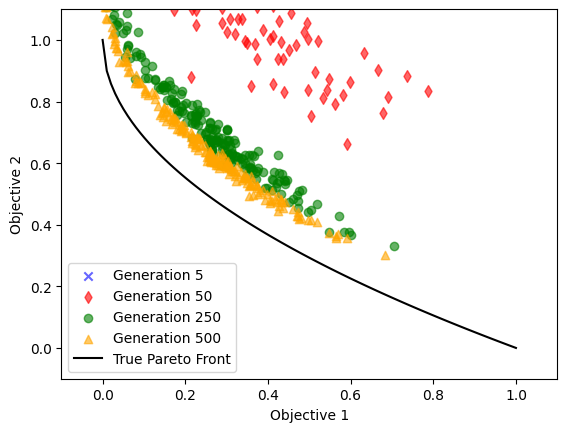

In [5]:
import numpy as np
import matplotlib.pyplot as plt

class MultiObjectiveDE:
    def __init__(self, population_size, num_generations, mutation_factor, crossover_rate):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate
        self.dimension = 30  # Number of parameters for ZDT1
        self.bounds = [0, 1]  # Parameter bounds for ZDT1

    # Initialize the candidate solutions within the given bounds
    def initialize_candidates(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimension))

    # Define the ZDT1 problem's objective functions
    @staticmethod
    def objective1(x):
        return x[0]

    @staticmethod
    def objective2(x):
        g = 1 + (9 / 29) * np.sum(x[1:])
        h = 1 - np.sqrt(x[0] / g)
        return g * h

    # Evaluate the candidate solutions by calculating their objective function values
    def evaluate_candidates(self, candidates):
        return np.array([[self.objective1(x), self.objective2(x)] for x in candidates])

    # Perform "current-to-best/1/bin" mutation to create mutant vectors
    def create_mutants(self, candidates, best_candidate):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 2, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 2, replace=False)
            a, b = candidates[indices]
            mutants[i] = candidates[i] + self.mutation_factor * (best_candidate - candidates[i]) + self.mutation_factor * (a - b)
            mutants[i] = np.clip(mutants[i], self.bounds[0], self.bounds[1])  # Ensure bounds
        return mutants

    # Perform crossover to generate trial vectors
    def perform_crossover(self, candidates, mutants):
        trials = np.zeros_like(candidates)
        for i in range(self.population_size):
            for j in range(self.dimension):
                if np.random.rand() < self.crossover_rate or j == np.random.randint(0, self.dimension):
                    trials[i, j] = mutants[i, j]
                else:
                    trials[i, j] = candidates[i, j]
        return trials

    # Ensure the trial vectors remain within the specified bounds
    def enforce_bounds(self, trials):
        trials = np.clip(trials, self.bounds[0], self.bounds[1])
        return trials

    # Check if one solution dominates another (Pareto dominance)
    @staticmethod
    def is_dominant(p, q):
        return (p <= q).all() and (p < q).any()

    # Select the best individuals to form the next generation
    def select_next_generation(self, candidates, trials, candidate_values, trial_values):
        new_population = []
        new_values = []
        for i in range(self.population_size):
            if self.is_dominant(trial_values[i], candidate_values[i]):
                new_population.append(trials[i])
                new_values.append(trial_values[i])
            else:
                new_population.append(candidates[i])
                new_values.append(candidate_values[i])
        return np.array(new_population), np.array(new_values)

    # Execute one complete trial of the DE algorithm
    def execute_trial(self):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Select the best candidate based on the second objective
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants(candidates, best_candidate)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)
            best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Update the best candidate

            # Save objective values at specific generations for analysis
            if generation in [5, 50, 250, 500]:
                print(f"Generation {generation} - First Candidate: {candidates[0]}")  # Debugging output
                print(f"Objective Values: {candidate_values[0]}")  # Debugging output
                yield generation, candidate_values

    # Plot the candidate solutions in the objective space
    @staticmethod
    def plot_solutions(candidate_values, color, marker, label):
        plt.scatter(candidate_values[:, 0], candidate_values[:, 1], c=color, marker=marker, label=label, alpha=0.6)

    # Run multiple trials of the DE algorithm and plot the results
    def run_and_plot(self):
        generations_to_plot = [5, 50, 250, 500]
        colors = ['blue', 'red', 'green', 'orange']
        markers = ['x', 'd', 'o', '^']

        for generation, candidate_values in self.execute_trial():
            if generation in generations_to_plot:
                label = f'Generation {generation}'
                color = colors[generations_to_plot.index(generation)]
                marker = markers[generations_to_plot.index(generation)]
                self.plot_solutions(candidate_values, color, marker, label)

        # Plot the true Pareto front
        x_values = np.linspace(0, 1, 100)
        y_values = 1 - np.sqrt(x_values)
        plt.plot(x_values, y_values, 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.savefig("pareto_zdt1", bbox_inches='tight')
        plt.show()

# Parameters for the DE algorithm
population_size = 200  # Increased population size
num_generations = 500  # Increased number of generations
mutation_factor = 0.8
crossover_rate = 0.9

# Create an instance of the MultiObjectiveDE class and run the trial
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)
de_instance.run_and_plot()


Generation 5 - First Candidate: [0.76410129 0.20602102 0.24862575 1.         0.         0.19132006
 0.         0.34840738 0.41029497 0.26552901 0.85661175 0.7827553
 0.09907024 0.         0.80730108 0.39626346 0.77035185 0.40115361
 0.4493983  0.01575282 0.67046314 0.40142126 0.         0.12475758
 0.32438593 0.         0.5090954  1.         0.14469065 0.        ]
Objective Values: [0.76410129 2.43606671]
Generation 50 - First Candidate: [4.65502974e-01 5.80815216e-02 0.00000000e+00 3.10626199e-01
 0.00000000e+00 9.43400854e-04 0.00000000e+00 2.26715248e-02
 1.01721582e-01 2.45678246e-02 5.95880261e-01 1.00000000e+00
 3.19668192e-01 8.60149921e-02 0.00000000e+00 2.24500084e-02
 7.31490899e-02 0.00000000e+00 1.00652784e-01 7.41751258e-02
 0.00000000e+00 8.27497984e-01 9.64667062e-02 5.01119500e-03
 1.87861173e-02 4.97955368e-01 9.06539611e-02 2.52208723e-01
 0.00000000e+00 2.24790636e-02]
Objective Values: [0.46550297 1.36495154]
Generation 250 - First Candidate: [2.61767591e-01 9.29762

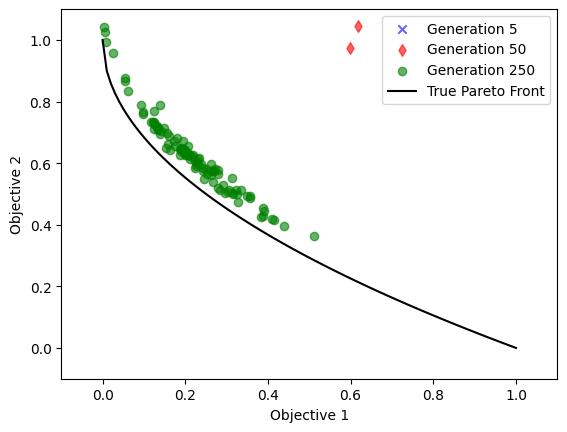

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class MultiObjectiveDE:
    def __init__(self, population_size, num_generations, mutation_factor, crossover_rate):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate
        self.dimension = 30  # Number of parameters for ZDT1
        self.bounds = [0, 1]  # Parameter bounds for ZDT1

    # Initialize the candidate solutions within the given bounds
    def initialize_candidates(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimension))

    # Define the ZDT1 problem's objective functions
    @staticmethod
    def objective1(x):
        return x[0]

    @staticmethod
    def objective2(x):
        g = 1 + (9 / 29) * np.sum(x[1:])
        h = 1 - np.sqrt(x[0] / g)
        return g * h

    # Evaluate the candidate solutions by calculating their objective function values
    def evaluate_candidates(self, candidates):
        return np.array([[self.objective1(x), self.objective2(x)] for x in candidates])

    # Perform "current-to-best/1/bin" mutation to create mutant vectors
    def create_mutants(self, candidates, best_candidate):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 2, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 2, replace=False)
            a, b = candidates[indices]
            mutants[i] = candidates[i] + self.mutation_factor * (best_candidate - candidates[i]) + self.mutation_factor * (a - b)
            mutants[i] = np.clip(mutants[i], self.bounds[0], self.bounds[1])  # Ensure bounds
        return mutants

    # Perform crossover to generate trial vectors
    def perform_crossover(self, candidates, mutants):
        trials = np.zeros_like(candidates)
        for i in range(self.population_size):
            for j in range(self.dimension):
                if np.random.rand() < self.crossover_rate or j == np.random.randint(0, self.dimension):
                    trials[i, j] = mutants[i, j]
                else:
                    trials[i, j] = candidates[i, j]
        return trials

    # Ensure the trial vectors remain within the specified bounds
    def enforce_bounds(self, trials):
        trials = np.clip(trials, self.bounds[0], self.bounds[1])
        return trials

    # Check if one solution dominates another (Pareto dominance)
    @staticmethod
    def is_dominant(p, q):
        return (p <= q).all() and (p < q).any()

    # Select the best individuals to form the next generation
    def select_next_generation(self, candidates, trials, candidate_values, trial_values):
        new_population = []
        new_values = []
        for i in range(self.population_size):
            if self.is_dominant(trial_values[i], candidate_values[i]):
                new_population.append(trials[i])
                new_values.append(trial_values[i])
            else:
                new_population.append(candidates[i])
                new_values.append(candidate_values[i])
        return np.array(new_population), np.array(new_values)

    # Execute one complete trial of the DE algorithm
    def execute_trial(self):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Select the best candidate based on the second objective
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants(candidates, best_candidate)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)
            best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Update the best candidate

            # Save objective values at specific generations for analysis
            if generation in [5, 50, 250]:
                print(f"Generation {generation} - First Candidate: {candidates[0]}")  # Debugging output
                print(f"Objective Values: {candidate_values[0]}")  # Debugging output
                yield generation, candidate_values

    # Plot the candidate solutions in the objective space
    @staticmethod
    def plot_solutions(candidate_values, color, marker, label):
        plt.scatter(candidate_values[:, 0], candidate_values[:, 1], c=color, marker=marker, label=label, alpha=0.6)

    # Run multiple trials of the DE algorithm and plot the results
    def run_and_plot(self):
        generations_to_plot = [5, 50, 250]
        colors = ['blue', 'red', 'green']
        markers = ['x', 'd', 'o']

        for generation, candidate_values in self.execute_trial():
            if generation in generations_to_plot:
                label = f'Generation {generation}'
                color = colors[generations_to_plot.index(generation)]
                marker = markers[generations_to_plot.index(generation)]
                self.plot_solutions(candidate_values, color, marker, label)

        # Plot the true Pareto front
        x_values = np.linspace(0, 1, 100)
        y_values = 1 - np.sqrt(x_values)
        plt.plot(x_values, y_values, 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(-0.1, 1.1)
        plt.ylim(-0.1, 1.1)
        plt.savefig("pareto_zdt1.png", bbox_inches='tight')
        plt.show()

# Parameters for the DE algorithm
population_size = 100  # Adjusted population size to 100
num_generations = 250  # Number of generations to run
mutation_factor = 0.8
crossover_rate = 0.9

# Create an instance of the MultiObjectiveDE class and run the trial
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)
de_instance.run_and_plot()


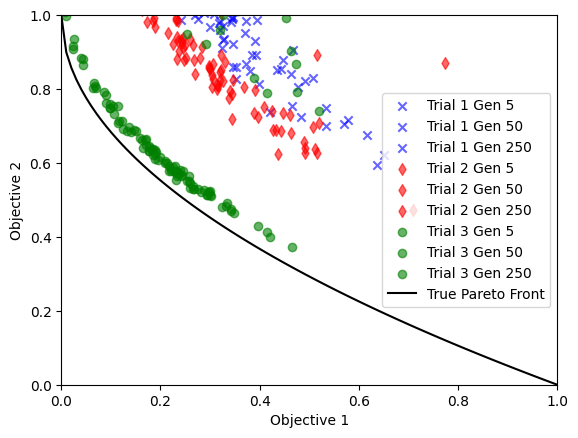

In [8]:
import numpy as np
import matplotlib.pyplot as plt

class MultiObjectiveDE:
    def __init__(self, population_size, num_generations, mutation_factor, crossover_rate):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate
        self.dimension = 30  # Number of parameters for ZDT1
        self.bounds = [0, 1]  # Parameter bounds for ZDT1

    # Initialize the candidate solutions within the given bounds
    def initialize_candidates(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimension))

    # Define the ZDT1 problem's objective functions
    @staticmethod
    def objective1(x):
        return x[0]

    @staticmethod
    def objective2(x):
        g = 1 + (9 / 29) * np.sum(x[1:])
        h = 1 - np.sqrt(x[0] / g)
        return g * h

    # Evaluate the candidate solutions by calculating their objective function values
    def evaluate_candidates(self, candidates):
        return np.array([[self.objective1(x), self.objective2(x)] for x in candidates])

    # Perform "current-to-best/1/bin" mutation to create mutant vectors
    def create_mutants(self, candidates, best_candidate):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 2, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 2, replace=False)
            a, b = candidates[indices]
            mutants[i] = candidates[i] + self.mutation_factor * (best_candidate - candidates[i]) + self.mutation_factor * (a - b)
            mutants[i] = np.clip(mutants[i], self.bounds[0], self.bounds[1])  # Ensure bounds
        return mutants

    # Perform crossover to generate trial vectors
    def perform_crossover(self, candidates, mutants):
        trials = np.zeros_like(candidates)
        for i in range(self.population_size):
            for j in range(self.dimension):
                if np.random.rand() < self.crossover_rate or j == np.random.randint(0, self.dimension):
                    trials[i, j] = mutants[i, j]
                else:
                    trials[i, j] = candidates[i, j]
        return trials

    # Ensure the trial vectors remain within the specified bounds
    def enforce_bounds(self, trials):
        trials = np.clip(trials, self.bounds[0], self.bounds[1])
        return trials

    # Check if one solution dominates another (Pareto dominance)
    @staticmethod
    def is_dominant(p, q):
        return (p <= q).all() and (p < q).any()

    # Select the best individuals to form the next generation
    def select_next_generation(self, candidates, trials, candidate_values, trial_values):
        new_population = []
        new_values = []
        for i in range(self.population_size):
            if self.is_dominant(trial_values[i], candidate_values[i]):
                new_population.append(trials[i])
                new_values.append(trial_values[i])
            else:
                new_population.append(candidates[i])
                new_values.append(candidate_values[i])
        return np.array(new_population), np.array(new_values)

    # Execute one complete trial of the DE algorithm
    def execute_trial(self):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Select the best candidate based on the second objective
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants(candidates, best_candidate)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)
            best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Update the best candidate

            # Save objective values at specific generations for analysis
            if generation in [5, 50, 250]:
                yield generation, candidate_values

    # Plot the candidate solutions in the objective space
    @staticmethod
    def plot_solutions(candidate_values, color, marker, label):
        plt.scatter(candidate_values[:, 0], candidate_values[:, 1], c=color, marker=marker, label=label, alpha=0.6)

    # Run multiple trials of the DE algorithm and plot the results
    def run_and_plot(self, num_trials=3):
        generations_to_plot = [5, 50, 250]
        colors = ['blue', 'red', 'green', 'cyan', 'magenta', 'yellow']
        markers = ['x', 'd', 'o', 's', '^', 'v']
        
        for trial in range(num_trials):
            for generation, candidate_values in self.execute_trial():
                if generation in generations_to_plot:
                    label = f'Trial {trial + 1} Gen {generation}'
                    color = colors[trial % len(colors)]
                    marker = markers[trial % len(markers)]
                    self.plot_solutions(candidate_values, color, marker, label)

        # Plot the true Pareto front
        x_values = np.linspace(0, 1, 100)
        y_values = 1 - np.sqrt(x_values)
        plt.plot(x_values, y_values, 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.savefig("pareto_zdt1_multiple_trials.png", bbox_inches='tight')
        plt.show()

# Parameters for the DE algorithm
population_size = 100  # Adjusted population size to 100
num_generations = 250  # Number of generations to run
mutation_factor = 0.8
crossover_rate = 0.9

# Create an instance of the MultiObjectiveDE class and run the trial
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)
de_instance.run_and_plot(num_trials=3)


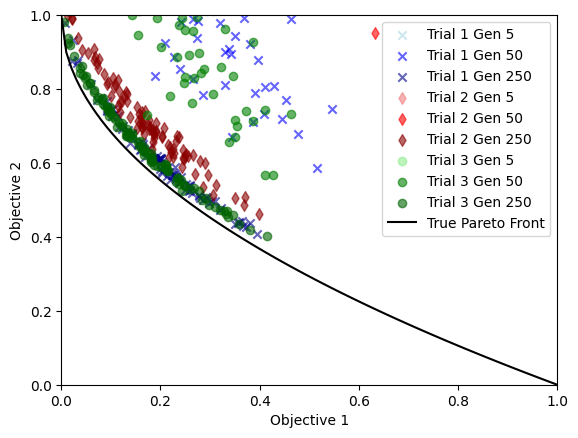

In [9]:
import numpy as np
import matplotlib.pyplot as plt

class MultiObjectiveDE:
    def __init__(self, population_size, num_generations, mutation_factor, crossover_rate):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate
        self.dimension = 30  # Number of parameters for ZDT1
        self.bounds = [0, 1]  # Parameter bounds for ZDT1

    # Initialize the candidate solutions within the given bounds
    def initialize_candidates(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimension))

    # Define the ZDT1 problem's objective functions
    @staticmethod
    def objective1(x):
        return x[0]

    @staticmethod
    def objective2(x):
        g = 1 + (9 / 29) * np.sum(x[1:])
        h = 1 - np.sqrt(x[0] / g)
        return g * h

    # Evaluate the candidate solutions by calculating their objective function values
    def evaluate_candidates(self, candidates):
        return np.array([[self.objective1(x), self.objective2(x)] for x in candidates])

    # Perform "current-to-best/1/bin" mutation to create mutant vectors
    def create_mutants(self, candidates, best_candidate):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 2, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 2, replace=False)
            a, b = candidates[indices]
            mutants[i] = candidates[i] + self.mutation_factor * (best_candidate - candidates[i]) + self.mutation_factor * (a - b)
            mutants[i] = np.clip(mutants[i], self.bounds[0], self.bounds[1])  # Ensure bounds
        return mutants

    # Perform crossover to generate trial vectors
    def perform_crossover(self, candidates, mutants):
        trials = np.zeros_like(candidates)
        for i in range(self.population_size):
            for j in range(self.dimension):
                if np.random.rand() < self.crossover_rate or j == np.random.randint(0, self.dimension):
                    trials[i, j] = mutants[i, j]
                else:
                    trials[i, j] = candidates[i, j]
        return trials

    # Ensure the trial vectors remain within the specified bounds
    def enforce_bounds(self, trials):
        trials = np.clip(trials, self.bounds[0], self.bounds[1])
        return trials

    # Check if one solution dominates another (Pareto dominance)
    @staticmethod
    def is_dominant(p, q):
        return (p <= q).all() and (p < q).any()

    # Select the best individuals to form the next generation
    def select_next_generation(self, candidates, trials, candidate_values, trial_values):
        new_population = []
        new_values = []
        for i in range(self.population_size):
            if self.is_dominant(trial_values[i], candidate_values[i]):
                new_population.append(trials[i])
                new_values.append(trial_values[i])
            else:
                new_population.append(candidates[i])
                new_values.append(candidate_values[i])
        return np.array(new_population), np.array(new_values)

    # Execute one complete trial of the DE algorithm
    def execute_trial(self):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Select the best candidate based on the second objective
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants(candidates, best_candidate)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)
            best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Update the best candidate

            # Save objective values at specific generations for analysis
            if generation in [5, 50, 250]:
                yield generation, candidate_values

    # Plot the candidate solutions in the objective space
    @staticmethod
    def plot_solutions(candidate_values, color, marker, label):
        plt.scatter(candidate_values[:, 0], candidate_values[:, 1], c=color, marker=marker, label=label, alpha=0.6)

    # Run multiple trials of the DE algorithm and plot the results
    def run_and_plot(self, num_trials=3):
        generations_to_plot = [5, 50, 250]
        trial_colors = [['lightblue', 'blue', 'darkblue'], ['lightcoral', 'red', 'darkred'], ['lightgreen', 'green', 'darkgreen']]
        markers = ['x', 'd', 'o']
        
        for trial in range(num_trials):
            for generation, candidate_values in self.execute_trial():
                if generation in generations_to_plot:
                    label = f'Trial {trial + 1} Gen {generation}'
                    color = trial_colors[trial][generations_to_plot.index(generation)]
                    marker = markers[trial % len(markers)]
                    self.plot_solutions(candidate_values, color, marker, label)

        # Plot the true Pareto front
        x_values = np.linspace(0, 1, 100)
        y_values = 1 - np.sqrt(x_values)
        plt.plot(x_values, y_values, 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.savefig("pareto_zdt1_multiple_trials_shades.png", bbox_inches='tight')
        plt.show()

# Parameters for the DE algorithm
population_size = 100  # Adjusted population size to 100
num_generations = 250  # Number of generations to run
mutation_factor = 0.8
crossover_rate = 0.9

# Create an instance of the MultiObjectiveDE class and run the trial
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)
de_instance.run_and_plot(num_trials=3)


Running and plotting the original algorithm with reflection boundary strategy:


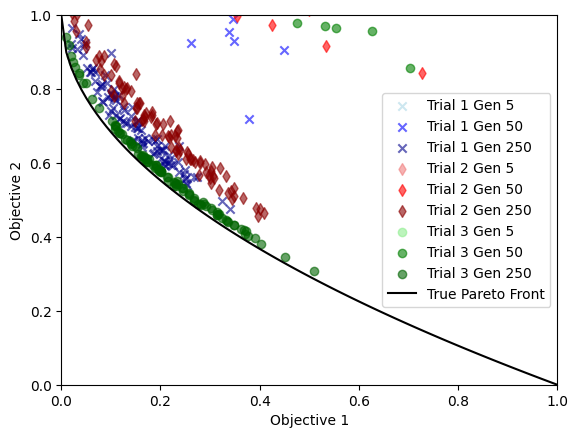

Running and plotting the original algorithm with set to bound boundary strategy:


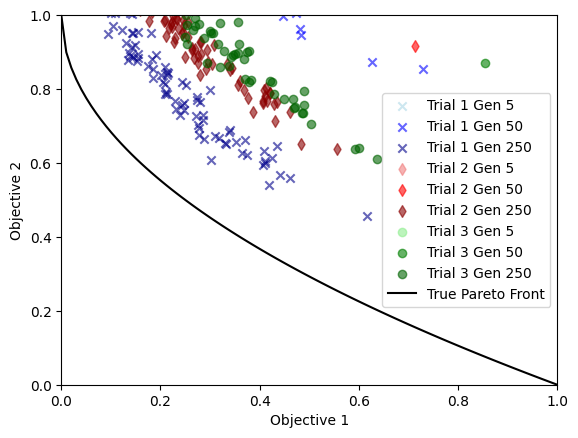

In [11]:
# PRT 4.4 
import numpy as np
import matplotlib.pyplot as plt

class MultiObjectiveDE:
    def __init__(self, population_size, num_generations, mutation_factor, crossover_rate):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate
        self.dimension = 30  # Number of parameters for ZDT1
        self.bounds = [0, 1]  # Parameter bounds for ZDT1

    def initialize_candidates(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimension))

    @staticmethod
    def objective1(x):
        return x[0]

    @staticmethod
    def objective2(x):
        g = 1 + (9 / 29) * np.sum(x[1:])
        h = 1 - np.sqrt(x[0] / g)
        return g * h

    def evaluate_candidates(self, candidates):
        return np.array([[self.objective1(x), self.objective2(x)] for x in candidates])

    def create_mutants(self, candidates, best_candidate):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 2, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 2, replace=False)
            a, b = candidates[indices]
            mutants[i] = candidates[i] + self.mutation_factor * (best_candidate - candidates[i]) + self.mutation_factor * (a - b)
            mutants[i] = np.clip(mutants[i], self.bounds[0], self.bounds[1])  # Ensure bounds
        return mutants

    def perform_crossover(self, candidates, mutants):
        trials = np.zeros_like(candidates)
        for i in range(self.population_size):
            for j in range(self.dimension):
                if np.random.rand() < self.crossover_rate or j == np.random.randint(0, self.dimension):
                    trials[i, j] = mutants[i, j]
                else:
                    trials[i, j] = candidates[i, j]
        return trials

    def enforce_bounds(self, trials, strategy='reflection'):
        if strategy == 'reflection':
            trials = np.where(trials < self.bounds[0], 2 * self.bounds[0] - trials, trials)
            trials = np.where(trials > self.bounds[1], 2 * self.bounds[1] - trials, trials)
        elif strategy == 'set_to_bound':
            trials = np.clip(trials, self.bounds[0], self.bounds[1])
        return trials

    @staticmethod
    def is_dominant(p, q):
        return (p <= q).all() and (p < q).any()

    def select_next_generation(self, candidates, trials, candidate_values, trial_values):
        new_population = []
        new_values = []
        for i in range(self.population_size):
            if self.is_dominant(trial_values[i], candidate_values[i]):
                new_population.append(trials[i])
                new_values.append(trial_values[i])
            else:
                new_population.append(candidates[i])
                new_values.append(candidate_values[i])
        return np.array(new_population), np.array(new_values)

    def execute_trial(self, boundary_strategy='reflection'):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Select the best candidate based on the second objective
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants(candidates, best_candidate)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials, strategy=boundary_strategy)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)
            best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Update the best candidate

            if generation in [5, 50, 250]:
                yield generation, candidate_values

    @staticmethod
    def plot_solutions(candidate_values, color, marker, label):
        plt.scatter(candidate_values[:, 0], candidate_values[:, 1], c=color, marker=marker, label=label, alpha=0.6)

    def run_and_plot(self, boundary_strategy, num_trials=3):
        generations_to_plot = [5, 50, 250]
        trial_colors = [['lightblue', 'blue', 'darkblue'], ['lightcoral', 'red', 'darkred'], ['lightgreen', 'green', 'darkgreen']]
        markers = ['x', 'd', 'o']
        
        for trial in range(num_trials):
            for generation, candidate_values in self.execute_trial(boundary_strategy=boundary_strategy):
                if generation in generations_to_plot:
                    label = f'Trial {trial + 1} Gen {generation}'
                    color = trial_colors[trial][generations_to_plot.index(generation)]
                    marker = markers[trial % len(markers)]
                    self.plot_solutions(candidate_values, color, marker, label)

        x_values = np.linspace(0, 1, 100)
        y_values = 1 - np.sqrt(x_values)
        plt.plot(x_values, y_values, 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.savefig(f"pareto_zdt1_{boundary_strategy}.png", bbox_inches='tight')
        plt.show()

# Parameters for the DE algorithm
population_size = 100
num_generations = 250
mutation_factor = 0.8
crossover_rate = 0.9

# Create an instance of the MultiObjectiveDE class
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)

# Run and plot the original algorithm with reflection boundary strategy
print("Running and plotting the original algorithm with reflection boundary strategy:")
de_instance.run_and_plot(boundary_strategy='reflection', num_trials=3)

# Run and plot the original algorithm with set to bound boundary strategy
print("Running and plotting the original algorithm with set to bound boundary strategy:")
de_instance.run_and_plot(boundary_strategy='set_to_bound', num_trials=3)


Running and plotting the algorithm with reflection boundary strategy:


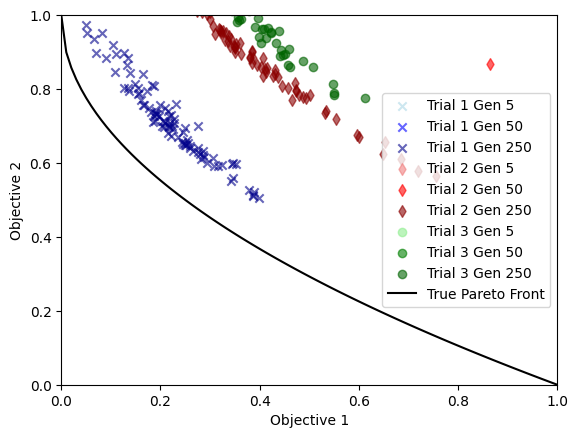

In [12]:
# problem 4.5
# Parameters for the DE algorithm
population_size = 100
num_generations = 250
mutation_factor = 0.6  # Experiment with different values, e.g., 0.5, 0.7, 0.8
crossover_rate = 0.9

# Create an instance of the MultiObjectiveDE class
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)

# Run and plot the algorithm with reflection boundary strategy
print("Running and plotting the algorithm with reflection boundary strategy:")
de_instance.run_and_plot(boundary_strategy='reflection', num_trials=3)


Running and plotting the algorithm with reflection boundary strategy:


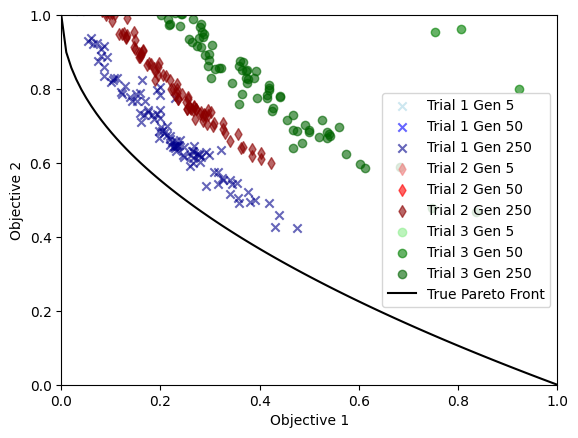

In [13]:
# Parameters for the DE algorithm
population_size = 100
num_generations = 250
mutation_factor = 0.7  # Experiment with different values, e.g., 0.5, 0.7, 0.8
crossover_rate = 0.9

# Create an instance of the MultiObjectiveDE class
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)

# Run and plot the algorithm with reflection boundary strategy
print("Running and plotting the algorithm with reflection boundary strategy:")
de_instance.run_and_plot(boundary_strategy='reflection', num_trials=3)


Running and plotting the algorithm with reflection boundary strategy:


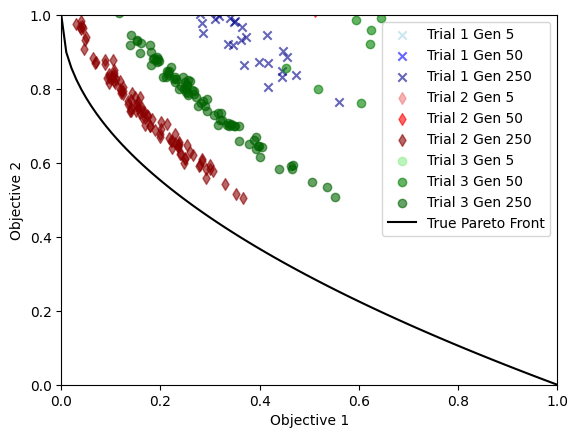

In [14]:
# Parameters for the DE algorithm
population_size = 100
num_generations = 250
mutation_factor = 0.8  # Experiment with different values, e.g., 0.5, 0.7, 0.8
crossover_rate = 0.9

# Create an instance of the MultiObjectiveDE class
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)

# Run and plot the algorithm with reflection boundary strategy
print("Running and plotting the algorithm with reflection boundary strategy:")
de_instance.run_and_plot(boundary_strategy='reflection', num_trials=3)


In [15]:
def create_mutants_alternative(self, candidates, best_candidate, lambda_de=0.5):
    mutants = np.zeros_like(candidates)
    for i in range(self.population_size):
        indices = np.random.choice(self.population_size, 2, replace=False)
        while i in indices:
            indices = np.random.choice(self.population_size, 2, replace=False)
        a, b = candidates[indices]
        mutants[i] = candidates[i] + self.mutation_factor * (a - b) + lambda_de * (best_candidate - candidates[i])
        mutants[i] = np.clip(mutants[i], self.bounds[0], self.bounds[1])  # Ensure bounds
    return mutants

def execute_trial_alternative(self, boundary_strategy='reflection', lambda_de=0.5):
    candidates = self.initialize_candidates()
    candidate_values = self.evaluate_candidates(candidates)
    best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Select the best candidate based on the second objective
    
    for generation in range(1, self.num_generations + 1):
        mutants = self.create_mutants_alternative(candidates, best_candidate, lambda_de)
        trials = self.perform_crossover(candidates, mutants)
        trials = self.enforce_bounds(trials, strategy=boundary_strategy)
        trial_values = self.evaluate_candidates(trials)
        candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)
        best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Update the best candidate

        if generation in [5, 50, 250]:
            yield generation, candidate_values

def run_and_plot_alternative(self, boundary_strategy='reflection', lambda_de=0.5, num_trials=3):
    generations_to_plot = [5, 50, 250]
    trial_colors = [['lightblue', 'blue', 'darkblue'], ['lightcoral', 'red', 'darkred'], ['lightgreen', 'green', 'darkgreen']]
    markers = ['x', 'd', 'o']
    
    for trial in range(num_trials):
        for generation, candidate_values in self.execute_trial_alternative(boundary_strategy=boundary_strategy, lambda_de=lambda_de):
            if generation in generations_to_plot:
                label = f'Trial {trial + 1} Gen {generation}'
                color = trial_colors[trial][generations_to_plot.index(generation)]
                marker = markers[trial % len(markers)]
                self.plot_solutions(candidate_values, color, marker, label)

    x_values = np.linspace(0, 1, 100)
    y_values = 1 - np.sqrt(x_values)
    plt.plot(x_values, y_values, 'k-', label='True Pareto Front')
    plt.xlabel('Objective 1')
    plt.ylabel('Objective 2')
    plt.legend()
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.savefig(f"pareto_zdt1_alternative_{boundary_strategy}.png", bbox_inches='tight')
    plt.show()


Running and plotting the alternative algorithm with reflection boundary strategy:


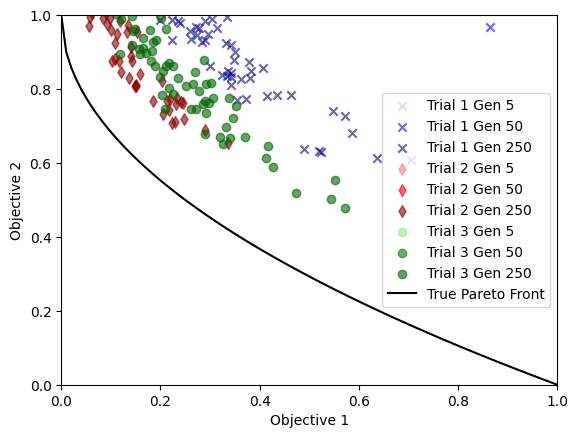

Running and plotting the alternative algorithm with set to bound boundary strategy:


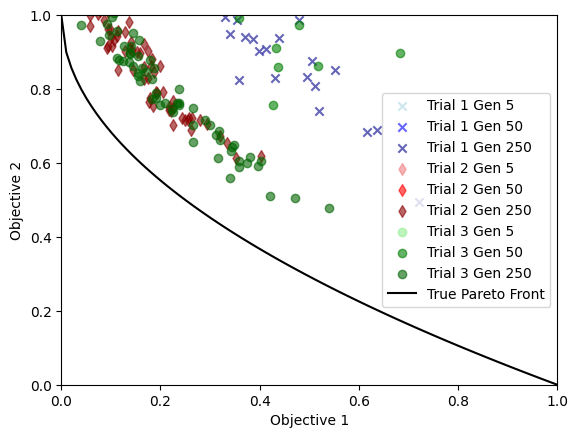

In [18]:
import numpy as np
import matplotlib.pyplot as plt

class MultiObjectiveDE:
    def __init__(self, population_size, num_generations, mutation_factor, crossover_rate):
        self.population_size = population_size
        self.num_generations = num_generations
        self.mutation_factor = mutation_factor
        self.crossover_rate = crossover_rate
        self.dimension = 30  # Number of parameters for ZDT1
        self.bounds = [0, 1]  # Parameter bounds for ZDT1

    def initialize_candidates(self):
        return np.random.uniform(self.bounds[0], self.bounds[1], (self.population_size, self.dimension))

    @staticmethod
    def objective1(x):
        return x[0]

    @staticmethod
    def objective2(x):
        g = 1 + (9 / 29) * np.sum(x[1:])
        h = 1 - np.sqrt(x[0] / g)
        return g * h

    def evaluate_candidates(self, candidates):
        return np.array([[self.objective1(x), self.objective2(x)] for x in candidates])

    def create_mutants(self, candidates, best_candidate):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 2, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 2, replace=False)
            a, b = candidates[indices]
            mutants[i] = candidates[i] + self.mutation_factor * (best_candidate - candidates[i]) + self.mutation_factor * (a - b)
            mutants[i] = np.clip(mutants[i], self.bounds[0], self.bounds[1])  # Ensure bounds
        return mutants

    def create_mutants_alternative(self, candidates, best_candidate, lambda_de=0.5):
        mutants = np.zeros_like(candidates)
        for i in range(self.population_size):
            indices = np.random.choice(self.population_size, 2, replace=False)
            while i in indices:
                indices = np.random.choice(self.population_size, 2, replace=False)
            a, b = candidates[indices]
            mutants[i] = candidates[i] + self.mutation_factor * (a - b) + lambda_de * (best_candidate - candidates[i])
            mutants[i] = np.clip(mutants[i], self.bounds[0], self.bounds[1])  # Ensure bounds
        return mutants

    def perform_crossover(self, candidates, mutants):
        trials = np.zeros_like(candidates)
        for i in range(self.population_size):
            for j in range(self.dimension):
                if np.random.rand() < self.crossover_rate or j == np.random.randint(0, self.dimension):
                    trials[i, j] = mutants[i, j]
                else:
                    trials[i, j] = candidates[i, j]
        return trials

    def enforce_bounds(self, trials, strategy='reflection'):
        if strategy == 'reflection':
            trials = np.where(trials < self.bounds[0], 2 * self.bounds[0] - trials, trials)
            trials = np.where(trials > self.bounds[1], 2 * self.bounds[1] - trials, trials)
        elif strategy == 'set_to_bound':
            trials = np.clip(trials, self.bounds[0], self.bounds[1])
        return trials

    @staticmethod
    def is_dominant(p, q):
        return (p <= q).all() and (p < q).any()

    def select_next_generation(self, candidates, trials, candidate_values, trial_values):
        new_population = []
        new_values = []
        for i in range(self.population_size):
            if self.is_dominant(trial_values[i], candidate_values[i]):
                new_population.append(trials[i])
                new_values.append(trial_values[i])
            else:
                new_population.append(candidates[i])
                new_values.append(candidate_values[i])
        return np.array(new_population), np.array(new_values)

    def execute_trial(self, boundary_strategy='reflection'):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Select the best candidate based on the second objective
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants(candidates, best_candidate)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials, strategy=boundary_strategy)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)
            best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Update the best candidate

            if generation in [5, 50, 250]:
                yield generation, candidate_values

    def execute_trial_alternative(self, boundary_strategy='reflection', lambda_de=0.5):
        candidates = self.initialize_candidates()
        candidate_values = self.evaluate_candidates(candidates)
        best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Select the best candidate based on the second objective
        
        for generation in range(1, self.num_generations + 1):
            mutants = self.create_mutants_alternative(candidates, best_candidate, lambda_de)
            trials = self.perform_crossover(candidates, mutants)
            trials = self.enforce_bounds(trials, strategy=boundary_strategy)
            trial_values = self.evaluate_candidates(trials)
            candidates, candidate_values = self.select_next_generation(candidates, trials, candidate_values, trial_values)
            best_candidate = candidates[np.argmin(candidate_values[:, 1])]  # Update the best candidate

            if generation in [5, 50, 250]:
                yield generation, candidate_values

    @staticmethod
    def plot_solutions(candidate_values, color, marker, label):
        plt.scatter(candidate_values[:, 0], candidate_values[:, 1], c=color, marker=marker, label=label, alpha=0.6)

    def run_and_plot(self, boundary_strategy, num_trials=3):
        generations_to_plot = [5, 50, 250]
        trial_colors = [['lightblue', 'blue', 'darkblue'], ['lightcoral', 'red', 'darkred'], ['lightgreen', 'green', 'darkgreen']]
        markers = ['x', 'd', 'o']
        
        for trial in range(num_trials):
            for generation, candidate_values in self.execute_trial(boundary_strategy=boundary_strategy):
                if generation in generations_to_plot:
                    label = f'Trial {trial + 1} Gen {generation}'
                    color = trial_colors[trial][generations_to_plot.index(generation)]
                    marker = markers[trial % len(markers)]
                    self.plot_solutions(candidate_values, color, marker, label)

        x_values = np.linspace(0, 1, 100)
        y_values = 1 - np.sqrt(x_values)
        plt.plot(x_values, y_values, 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.savefig(f"pareto_zdt1_{boundary_strategy}.png", bbox_inches='tight')
        plt.show()

    def run_and_plot_alternative(self, boundary_strategy='reflection', lambda_de=0.5, num_trials=3):
        generations_to_plot = [5, 50, 250]
        trial_colors = [['lightblue', 'blue', 'darkblue'], ['lightcoral', 'red', 'darkred'], ['lightgreen', 'green', 'darkgreen']]
        markers = ['x', 'd', 'o']
        
        for trial in range(num_trials):
            for generation, candidate_values in self.execute_trial_alternative(boundary_strategy=boundary_strategy, lambda_de=lambda_de):
                if generation in generations_to_plot:
                    label = f'Trial {trial + 1} Gen {generation}'
                    color = trial_colors[trial][generations_to_plot.index(generation)]
                    marker = markers[trial % len(markers)]
                    self.plot_solutions(candidate_values, color, marker, label)

        x_values = np.linspace(0, 1, 100)
        y_values = 1 - np.sqrt(x_values)
        plt.plot(x_values, y_values, 'k-', label='True Pareto Front')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.legend()
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.savefig(f"pareto_zdt1_alternative_{boundary_strategy}.png", bbox_inches='tight')
        plt.show()

# Parameters for the DE algorithm
population_size = 100
num_generations = 250
mutation_factor = 0.8
crossover_rate = 0.9
lambda_de = 0.5  # Experiment with different values, e.g., 0.3, 0.5, 0.7

# Create an instance of the MultiObjectiveDE class
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)

# Run and plot the alternative algorithm with reflection boundary strategy
print("Running and plotting the alternative algorithm with reflection boundary strategy:")
de_instance.run_and_plot_alternative(boundary_strategy='reflection', lambda_de=lambda_de, num_trials=3)

# Run and plot the alternative algorithm with set to bound boundary strategy
print("Running and plotting the alternative algorithm with set to bound boundary strategy:")
de_instance.run_and_plot_alternative(boundary_strategy='set_to_bound', lambda_de=lambda_de, num_trials=3)


Running and plotting the alternative algorithm with reflection boundary strategy:


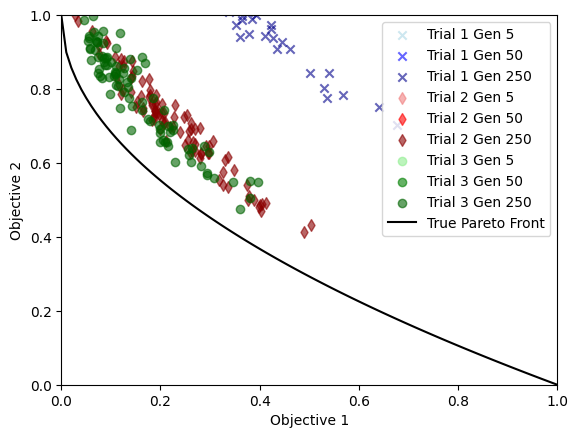

Running and plotting the alternative algorithm with set to bound boundary strategy:


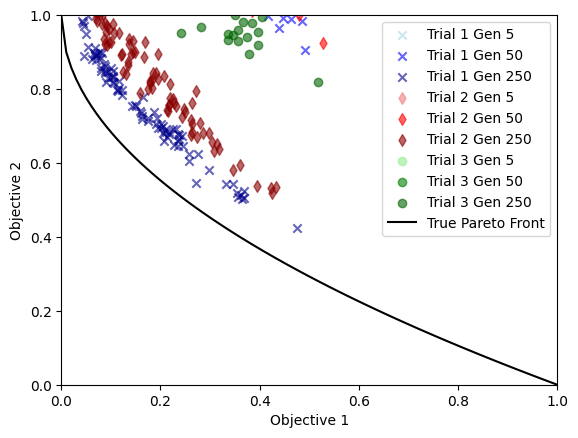

In [19]:
# Parameters for the DE algorithm
population_size = 100
num_generations = 250
mutation_factor = 0.8
crossover_rate = 0.9
lambda_de = 0.7  # Experiment with different values, e.g., 0.3, 0.5, 0.7

# Create an instance of the MultiObjectiveDE class
de_instance = MultiObjectiveDE(population_size, num_generations, mutation_factor, crossover_rate)

# Run and plot the alternative algorithm with reflection boundary strategy
print("Running and plotting the alternative algorithm with reflection boundary strategy:")
de_instance.run_and_plot_alternative(boundary_strategy='reflection', lambda_de=lambda_de, num_trials=3)

# Run and plot the alternative algorithm with set to bound boundary strategy
print("Running and plotting the alternative algorithm with set to bound boundary strategy:")
de_instance.run_and_plot_alternative(boundary_strategy='set_to_bound', lambda_de=lambda_de, num_trials=3)
